In [78]:
import numpy as np
import pandas as pd

In [79]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("anchit48/fine-tuned-sentiment-analysis-customer-feedback")
model = AutoModelForSequenceClassification.from_pretrained("anchit48/fine-tuned-sentiment-analysis-customer-feedback")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [80]:
import torch

text = "Mirissa Beach is truly a gem on Sri Lanka’s southern coast! The soft, golden sand and crystal-clear waters are perfect for lounging or taking a dip"

def make_prediction(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()

    return predicted_class

In [81]:
negetive = "this very bad place I dont want to be here"
make_prediction(negetive)

0

In [82]:
df = pd.read_excel('/content/Places Dataset.xlsx')
df.head()

,name,lat,lng,formatted_address,rating,user_ratings_total,latest_reviews
0,Arugam Bay Beach,6.840408,81.836848,"Arugam Bay Beach, Sri Lanka",4.8,1591.0,['Arugam Bay Beach is a surfer's paradise! I s...
1,Mirissa Beach,5.944703,80.459161,"Mirissa, Sri Lanka",4.6,1748.0,['Mirissa Beach is truly a gem on Sri LankaÃ¢Â...
2,Weligama Beach (surf and stay),5.972486,80.435714,"Weligama, Sri Lanka",4.4,325.0,['Weligama Beach is a fantastic spot for both ...
3,Ahangama,5.973975,80.362159,"Ahangama, Sri Lanka",NaN,NaN,['Ahangama was a bit disappointing for me as a...
4,Hikkaduwa Beach,6.137727,80.099060,"Hikkaduwa Beach, Sri Lanka",4.7,1438.0,['Hikkaduwa Beach is a delightful escape for s...


In [83]:
df.shape

(411, 7)

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411 entries, 0 to 410
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                411 non-null    object 
 1   lat                 410 non-null    float64
 2   lng                 410 non-null    float64
 3   formatted_address   411 non-null    object 
 4   rating              355 non-null    float64
 5   user_ratings_total  355 non-null    float64
 6   latest_reviews      411 non-null    object 
dtypes: float64(4), object(3)
memory usage: 22.6+ KB


In [85]:
import ast
import re

latest_reviews_array = []
classified_reviews_array = []
all_classified_reviews = []

def extract_list_item(string):
    string = string.replace("Ã¢Â€Â™", "'")
    string = string.replace("\\'", "'")
    string = re.sub(r'[^\x00-\x7F]+', '', string)

    try:
        match = re.search(r'\[(.*)\]', string)
        if match:
            reviews = match.group(1).split("', '")
            sub_array = []
            for item in reviews:
                cleaned_item = item.strip(" '")
                sub_array.append(make_prediction(cleaned_item))
                all_classified_reviews.append(make_prediction(cleaned_item))
                latest_reviews_array.append(cleaned_item)
            classified_reviews_array.append(sub_array)
        else:
            sub_array = [-1]
            classified_reviews_array.append(sub_array)

    except Exception as e:
        print(f"Error processing the string: {e}")

In [ ]:
df["latest_reviews"].apply(extract_list_item)

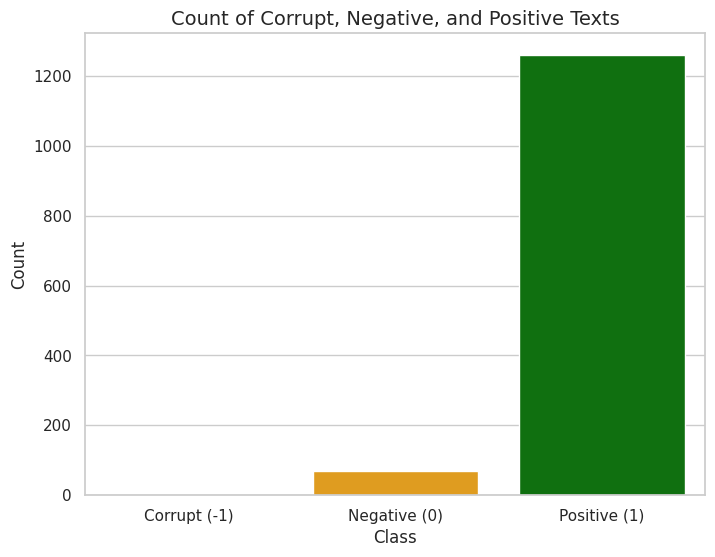

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

data = all_classified_reviews
counts = Counter(data)

df = pd.DataFrame({
    'Class': ['Corrupt (-1)', 'Negative (0)', 'Positive (1)'],
    'Count': [counts[-1], counts[0], counts[1]]
})

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(x='Class', y='Count', data=df, hue='Class', palette=['red', 'orange', 'green'], dodge=False, legend=False)

plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Count of Corrupt, Negative, and Positive Texts', fontsize=14)

plt.show()
